In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core

In [1]:
slack_webhook = "https://chat-langchain-langgraph-cl-d4a7041e91b655bab3bbd4fe1472e0cd.default.us.langgraph.app"

In [4]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import HumanMessage, SystemMessage

# Get remote graph
url = "https://reddit-radar-faf24d2655da52138764eb97ce47075c.default.us.langgraph.app"
graph_name = "reddit_radar" 
remote_graph = RemoteGraph(graph_name, url=url)


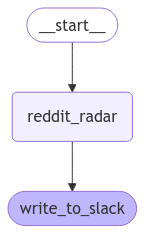

In [5]:
import requests
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, List, Annotated
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, END, START

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take",
    )
    take: str = Field(
        description="Fun, punchy observation about the newsworthy topic",
    )
    source_url: str = Field(
        description="Source data URL for information in the take (if applicable)",
    )
    reddit_url: str = Field(
        description="Reddit post URL for the post",
    )
    reasoning: str = Field(
        description="Provide your reasoning for the take, which confirms that the take is relevant to the newsworthy topic",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class OverallState(TypedDict):
    user: str
    context: str
    subreddit_name: str
    user_provided_topics:str
    takes: Annotated[List[Take], operator.add]

def write_to_slack(state: OverallState):
    """ Write takes to Slack """
    
    # Full set of interview reports
    takes = state["takes"]

    # Write to your Slack Channel via webhook
    true = True
    headers = {
        'Content-Type': 'application/json',
    }

    # Write to slack
    for t in takes:
        for take in t.takes:
            
            # Blocks
            blocks = []
            
            # Block 1: Title section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*{take.title}*"
                }
            })
            
            # Block 2: Divider
            blocks.append({
                "type": "divider"
            })
            
            # Block 3: Content section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"{take.take}"
                }
            })

            # Block 4: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 5: Source
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Source: {take.source_url}" 
                }
            })

            # Block 6: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 7: Reddit post
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Reddit post: {take.reddit_url}"
                }
            })
            
            blocks.insert(0, {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": ":fire: :robot_face: Take-Bot is heating up ...",
                    "emoji": true
                }
            })
            
            data = {
                "blocks": blocks,
                "unfurl_links": True,
                "unfurl_media": True,
            }
            
            response = requests.post(slack_webhook, headers=headers, json=data)

# Define parent graph
builder = StateGraph(OverallState)
builder.add_node("reddit_radar", remote_graph)
builder.add_node("write_to_slack", write_to_slack)
builder.add_edge(START, "reddit_radar")
builder.add_edge("reddit_radar", "write_to_slack")
graph = builder.compile()

# View 
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))